# Выпускной проект.

Чтобы оптимизировать производственные расходы, крупный металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Границы точности и успешности:
- MAE > 8.7 — 0 sp
- 7.6 < MAE ≤ 8.7 — 4 sp
- 6.8 < MAE ≤ 7.6 — 4.5 sp
- 6.3 < MAE ≤ 6.8 — 5 sp
- 6.0 < MAE ≤ 6.3 — 5.5 sp
- MAE ≤ 6.0 — 6 sp

## Содержание.  <a class="anchor" id="0-bullet">
* [1. Первичный анализ данных](#1-bullet)
* [2. Предобработка данных](#2-bullet)
* [3. Подбор и тестирование моделей](#3-bullet)
    * [3.1. Линейная регрессия](#3.1-bullet)
    * [3.2. Случайный лес](#3.2-bullet)
    * [3.3. CatBoostRegressor](#3.3-bullet)
    * [3.4. LGBMRegressor](#3.4-bullet)
    * [3.5. Проверка адекватности модели](#3.5-bullet)

# 1. Первичный анализ данных<a class="anchor" id="1-bullet"></a>

In [556]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

# зададим значение константы для random_state
RS = 100500

pd.options.display.max_columns = 45

import warnings
warnings.filterwarnings("ignore")

In [557]:
# считаем файлы данных
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [558]:
# напишем функцию для вывода информации о загруженных таблицах, которая также проверит на наличие дубликатов
# и, если таковые найдутся, удалит их
def inform(data):
    print(data.info())
    display(pd.concat([data.head(5), data.tail(5)]))
    print(data.describe())
    print('Количество дубликатов:', data.duplicated().sum())
    data = data.drop_duplicates().reset_index(drop = True)
    print('Количество дубликатов после удаления:', data.duplicated().sum())

<span style="color:purple">Последовательно посмотрим на каждую из таблиц.

### 1. <span style="color:purple">Данные об электродах (data_arc).

In [559]:
inform(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388
Количество дубликатов: 0
Количество дубликатов после удаления: 0


<span style="color:purple">Пропусков нет, дубликатов нет. Сразу бросается в глаза аномальное значение реактивной мощности (-715.50). Это выглядит как очевидная ошибка и такую запись имеет смысл удалить.

In [560]:
data_arc = data_arc[data_arc['Реактивная мощность'] >= 0]

<span style="color:purple">Посмотрим, есть ли выбросы для значений активной и реактивной мощностей.

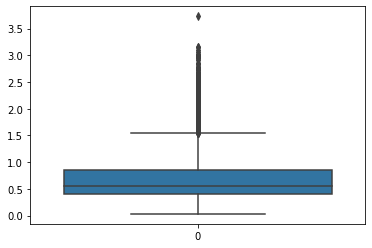

In [561]:
sns.boxplot(data = data_arc['Активная мощность'])

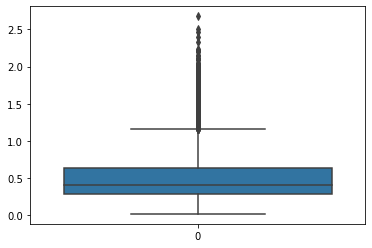

In [562]:
sns.boxplot(data = data_arc['Реактивная мощность'])

<span style="color:purple">Выбросы есть, но удалять их смысла нет - иначе получится избыточная выхолощенность, и модель будет слишком "тепличной" и оторванной от жизни.

<span style="color:purple">Приведём временнЫе признаки к типу datetime.

In [563]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

<span style="color:purple">Проверим, как соотносятся между собой активная мощность и реактивная мощность.

In [564]:
data_arc[['Активная мощность', 'Реактивная мощность']].corr()

,Активная мощность,Реактивная мощность
Активная мощность,1.000000,0.963182
Реактивная мощность,0.963182,1.000000


<span style="color:purple">Налицо очень высокая корреляция - 0.96. Из литературы известно, что часто используется параметр "Полная мощность", равный квадратному корню из суммы квадратов активной и реактивной мощностей. В дальнейшем будем использовать этот параметр.

In [565]:
data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)

In [566]:
display(pd.concat([data_arc.head(5), data_arc.tail(5)]))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708,0.364260


<span style="color:purple">Также выглядит разумным в дальнейшем использовать параметр "Время нагрева дугой", равный разности между временем окончания нагрева дугой и временем начала нагрева дугой.

### 2. <span style="color:purple">Данные о подаче сыпучих материалов (объём) - data_bulk

In [567]:
inform(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000  

<span style="color:purple">Сразу обращает на себя внимание огромное количество пропущенных значений. Скорее всего, пропуски означают, что сыпучие материалы не подавались, заполним их нулями.

In [568]:
data_bulk = data_bulk.fillna(0)

### 3. <span style="color:purple">Данные о подаче сыпучих материалов (время) - data_bulk_time

In [569]:
inform(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000
Количество дубликатов: 0
Количество дубликатов после удаления: 0


<span style="color:purple">Также много пропусков (когда нет данных по добавлению сыпучих материалов из таблицы data_bulk, нет и данных по времени добавления здесь, в таблице data_bulk_time. В дальнейшем эту таблицу использовать не будем.

### 4. <span style="color:purple">Данные о продувке сплава газом - data_gas

In [570]:
inform(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040
Количество дубликатов: 0
Количество дубликатов после удаления: 0


<span style="color:purple">Пропусков нет, дубликатов нет. В таблице представлены суммарные значения по продувке газом для каждой партии.

### 5. <span style="color:purple">Результаты измерения температуры - data_temp

In [571]:
inform(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000
Количество дубликатов: 0
Количество дубликатов после удаления: 0


<span style="color:purple">Дубликатов нет, есть много пропусков. Работу с ними отложим до этапа предобработки данных. Преобразуем время замера к типу datetime.

In [572]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

<span style="color:purple">Последнее значение температуры станет нашим целевым признаком. Посмотрим на ящик с усами.

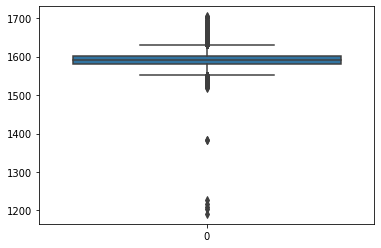

In [573]:
sns.boxplot(data = data_temp['Температура'])

<span style="color:purple">Выбросы есть. Известно, что температура плавления стали не может быть меньше 1350 градусов, значит значения ниже этой отметки - действительно выбросы. Удалим их ниже, на этапе предобработки данных.

### 6. <span style="color:purple">Данные о проволочных материалах (объём) - data_wire

In [574]:
inform(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060484    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     2

<span style="color:purple">В таблице очень много пропусков. Скорее всего, пропуски означают, что проволока не подавалась, заполним их нулями.

In [575]:
data_wire = data_wire.fillna(0)

### 7. <span style="color:purple">Данные о проволочных материалах (время) - data_wire_time

In [576]:
inform(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000
Количество дубликатов: 0
Количество дубликатов после удаления: 0


<span style="color:purple">Также много пропусков (когда нет данных по добавлению проволоки из таблицы data_wire, нет и данных по времени добавления здесь, в таблице data_wire_time. Эту таблицу мы в дальнейшем использовать не будем.

# 2. Предобработка данных<a class="anchor" id="2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Прежде всего поработаем с таблицей data_temp.

<span style="color:purple">В ней присутствует значительное количество пропусков, посмотрим, как они распределены.

In [577]:
data_temp[data_temp['Температура'].isnull()].head(10)

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
12274,2501,2019-08-06 04:22:14,NaN
12275,2501,2019-08-06 04:31:14,NaN
12277,2502,2019-08-06 04:46:04,NaN
12278,2502,2019-08-06 04:52:32,NaN
12279,2502,2019-08-06 04:57:30,NaN


<span style="color:purple">Мы видим, что значения температуры присутствуют только до партии с номером 2500. Оставим во всех таблицах данные для партий с номерами <= 2499.

In [578]:
data_temp = data_temp.query('key <= 2499')
data_arc = data_arc.query('key <= 2499')
data_bulk = data_bulk.query('key <= 2499')
data_wire = data_wire.query('key <= 2499')

<span style="color:purple">Как мы заметили выше, температура плавления стали не может быть ниже 1350 градусов Цельсия. Удалим аномальные значения.

In [579]:
data_temp = data_temp.query('Температура >= 1350')

<span style="color:purple">Для нас важно, чтобы для каждой партии существовало как минимум два измерения температуры - начальное и конечное. Проверим этот момент.

In [580]:
data_temp['key'].value_counts()

46      16
44      16
1513    16
1689    15
2108    15
        ..
2194     2
5        2
1631     2
195      1
279      1
Name: key, Length: 2477, dtype: int64

<span style="color:purple">Партии с номерами 195 и 279 нам не подойдут, их тоже необходимо удалить из всех таблиц.

In [581]:
data_temp = data_temp.query('key not in (195, 279)')
data_gas = data_gas.query('key not in (195, 279)')
data_bulk = data_bulk.query('key not in (195, 279)')
data_wire = data_wire.query('key not in (195, 279)')

<span style="color:purple">Найдём для каждой партии время первого и последнего замера температуры.

In [582]:
temp_first = data_temp.merge(pd.to_datetime(data_temp.groupby('key')['Время замера'].min()), on="Время замера").\
rename(columns={"Время замера": "Время первого замера", "Температура": "Начальная температура"})

In [583]:
temp_first.head()

,key,Время первого замера,Начальная температура
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0


In [584]:
temp_last = data_temp.merge(pd.to_datetime(data_temp.groupby('key')['Время замера'].max()), on="Время замера").\
rename(columns={"Время замера": "Время последнего замера", "Температура": "Конечная температура"})

In [585]:
temp_last.head()

,key,Время последнего замера,Конечная температура
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0


<span style="color:purple">Найдём количество замеров температуры для каждой партии.

In [586]:
temp_count = pd.pivot_table(data_temp[['key', 'Температура']],index='key',  aggfunc='count')
temp_count.columns = ['Количество замеров температуры']

In [587]:
temp_count.head()

,Количество замеров температуры
key,
1,5
2,6
3,5
4,3
5,2


<span style="color:purple">Соединим все температурные таблицы в одну и добавим столбец "Время между замерами" (в секундах).

In [588]:
temp_all = temp_count.merge(temp_first, on = 'key').merge(temp_last, on = 'key')

In [589]:
temp_all['Время между замерами'] = (temp_all['Время последнего замера'] - \
                                    temp_all['Время первого замера']).dt.seconds

In [590]:
display(temp_all.head())
print(temp_all.info())

,key,Количество замеров температуры,Время первого замера,Начальная температура,Время последнего замера,Конечная температура,Время между замерами
0,1,5,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,861
1,2,6,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,1305
2,3,5,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,1300
3,4,3,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,388
4,5,2,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,762


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 7 columns):
key                               2475 non-null int64
Количество замеров температуры    2475 non-null int64
Время первого замера              2475 non-null datetime64[ns]
Начальная температура             2475 non-null float64
Время последнего замера           2475 non-null datetime64[ns]
Конечная температура              2475 non-null float64
Время между замерами              2475 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(3)
memory usage: 154.7 KB
None


<span style="color:purple">Теперь обратимся к таблице data_arc.

<span style="color:purple">Посчитаем количество запусков нагрева для каждой партии.

In [591]:
count_arc = data_arc.groupby(by = 'key', as_index = False).count()[['key', 'Начало нагрева дугой']]
count_arc.columns = ['key', 'Количество запусков нагрева']

In [592]:
count_arc.head()

,key,Количество запусков нагрева
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4


<span style="color:purple">Добавим столбец "Время нагрева дугой", равный разности между последним и первым временем нагрева.

In [593]:
data_arc['Время нагрева дугой'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

<span style="color:purple">Сгруппируем данные по партиям.

In [594]:
data_arc = data_arc.groupby(by = 'key', as_index = False).sum()

<span style="color:purple">Объединим таблицы.

In [595]:
data_arc = data_arc.merge(count_arc, on = 'key')

In [596]:
display(data_arc.head(10))
print(data_arc.info())

,key,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева дугой,Количество запусков нагрева
0,1,4.878147,3.183241,5.826395,1098,5
1,2,3.052598,1.998112,3.649216,811,4
2,3,2.525882,1.599076,2.989534,655,5
3,4,3.209250,2.060298,3.814962,741,4
4,5,3.347173,2.252643,4.035758,869,4
5,6,3.955108,2.689175,4.786837,952,4
6,7,2.547375,1.561295,2.987777,673,4
7,8,3.762755,2.680698,4.627389,913,4
8,9,2.081951,1.478671,2.555348,625,5
9,10,2.923622,2.496116,3.851739,825,6


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 6 columns):
key                            2475 non-null int64
Активная мощность              2475 non-null float64
Реактивная мощность            2475 non-null float64
Полная мощность                2475 non-null float64
Время нагрева дугой            2475 non-null int64
Количество запусков нагрева    2475 non-null int64
dtypes: float64(3), int64(3)
memory usage: 135.4 KB
None


<span style="color:purple">Соберём теперь все данные в единую таблицу.

In [597]:
data_all = data_arc.merge(temp_all, on = 'key').merge(data_bulk, on = 'key').merge(data_gas, on = 'key').\
merge(data_wire, on = 'key')

<span style="color:purple">Удалим столбцы, которые не понадобятся нам в дальнейшем. Хотя полная мощность зависит от активной и реактивной, активную и реактивную мощности удалять не будем, без них предсказания получаются хуже. Данные по примесям оставим неизменными, ибо суммарные значения проволоки и сыпучих материалов вместо несуммируемых дают худшее качество.

In [598]:
data_all = data_all.drop(['key', 'Время первого замера', \
                          'Время последнего замера'], axis = 'columns')

<span style="color:purple">Переименуем столбцы, названия которых записаны кириллицей, для корректной работы LGBMRegressor

In [599]:
data_all = data_all.rename(columns={'Активная мощность': 'active_power',
                            'Полная мощность': 'full_power', 
                            'Реактивная мощность': 'reactive_power',
                            'Время нагрева дугой': 'arc_heating_time',
                            'Количество запусков нагрева': 'number_of_heating_starts',
                            'Количество замеров температуры':'number_ of_temperature_measurements',
                            'Начальная температура':'first_temperature',
                            'Конечная температура':'last_temperature',
                            'Время между замерами':'time_between_measurements',
                            'Газ 1': 'gas_1'})

In [600]:
inform(data_all)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 34 columns):
active_power                           2329 non-null float64
reactive_power                         2329 non-null float64
full_power                             2329 non-null float64
arc_heating_time                       2329 non-null int64
number_of_heating_starts               2329 non-null int64
number_ of_temperature_measurements    2329 non-null int64
first_temperature                      2329 non-null float64
last_temperature                       2329 non-null float64
time_between_measurements              2329 non-null int64
Bulk 1                                 2329 non-null float64
Bulk 2                                 2329 non-null float64
Bulk 3                                 2329 non-null float64
Bulk 4                                 2329 non-null float64
Bulk 5                                 2329 non-null float64
Bulk 6                                 2329 non

,active_power,reactive_power,full_power,arc_heating_time,number_of_heating_starts,number_ of_temperature_measurements,first_temperature,last_temperature,time_between_measurements,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas_1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,4.878147,3.183241,5.826395,1098,5,5,1571.0,1613.0,861,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.052598,1.998112,3.649216,811,4,6,1581.0,1602.0,1305,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.525882,1.599076,2.989534,655,5,5,1596.0,1599.0,1300,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.209250,2.060298,3.814962,741,4,3,1601.0,1625.0,388,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.347173,2.252643,4.035758,869,4,2,1576.0,1602.0,762,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2324,3.210690,2.360777,3.986869,723,4,3,1570.0,1591.0,1137,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,4.203064,2.810185,5.057033,940,6,4,1554.0,1591.0,1618,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2.212379,1.851269,2.885017,569,3,2,1571.0,1589.0,717,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,3.408725,2.355428,4.143749,750,5,5,1591.0,1594.0,1302,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2328,4.098431,2.777865,4.953010,883,4,3,1569.0,1603.0,1203,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0,11.336151,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0


       active_power  reactive_power   full_power  arc_heating_time  \
count   2329.000000     2329.000000  2329.000000       2329.000000   
mean       3.152236        2.351068     3.941677        807.600687   
std        1.425522        1.081806     1.779518        340.897332   
min        0.186226        0.158247     0.257637         57.000000   
25%        2.173277        1.626854     2.735080        581.000000   
50%        3.028334        2.234997     3.773603        778.000000   
75%        3.920676        2.915089     4.892791        993.000000   
max       17.496497       12.587990    21.564771       4189.000000   

       number_of_heating_starts  number_ of_temperature_measurements  \
count               2329.000000                          2329.000000   
mean                   4.695148                             4.982825   
std                    1.606948                             1.794574   
min                    1.000000                             2.000000   
25%      

In [601]:
display(data_all.shape)

(2329, 34)

<span style="color:purple">Посмотрим на корреляцию признаков в финальной таблице.<span>

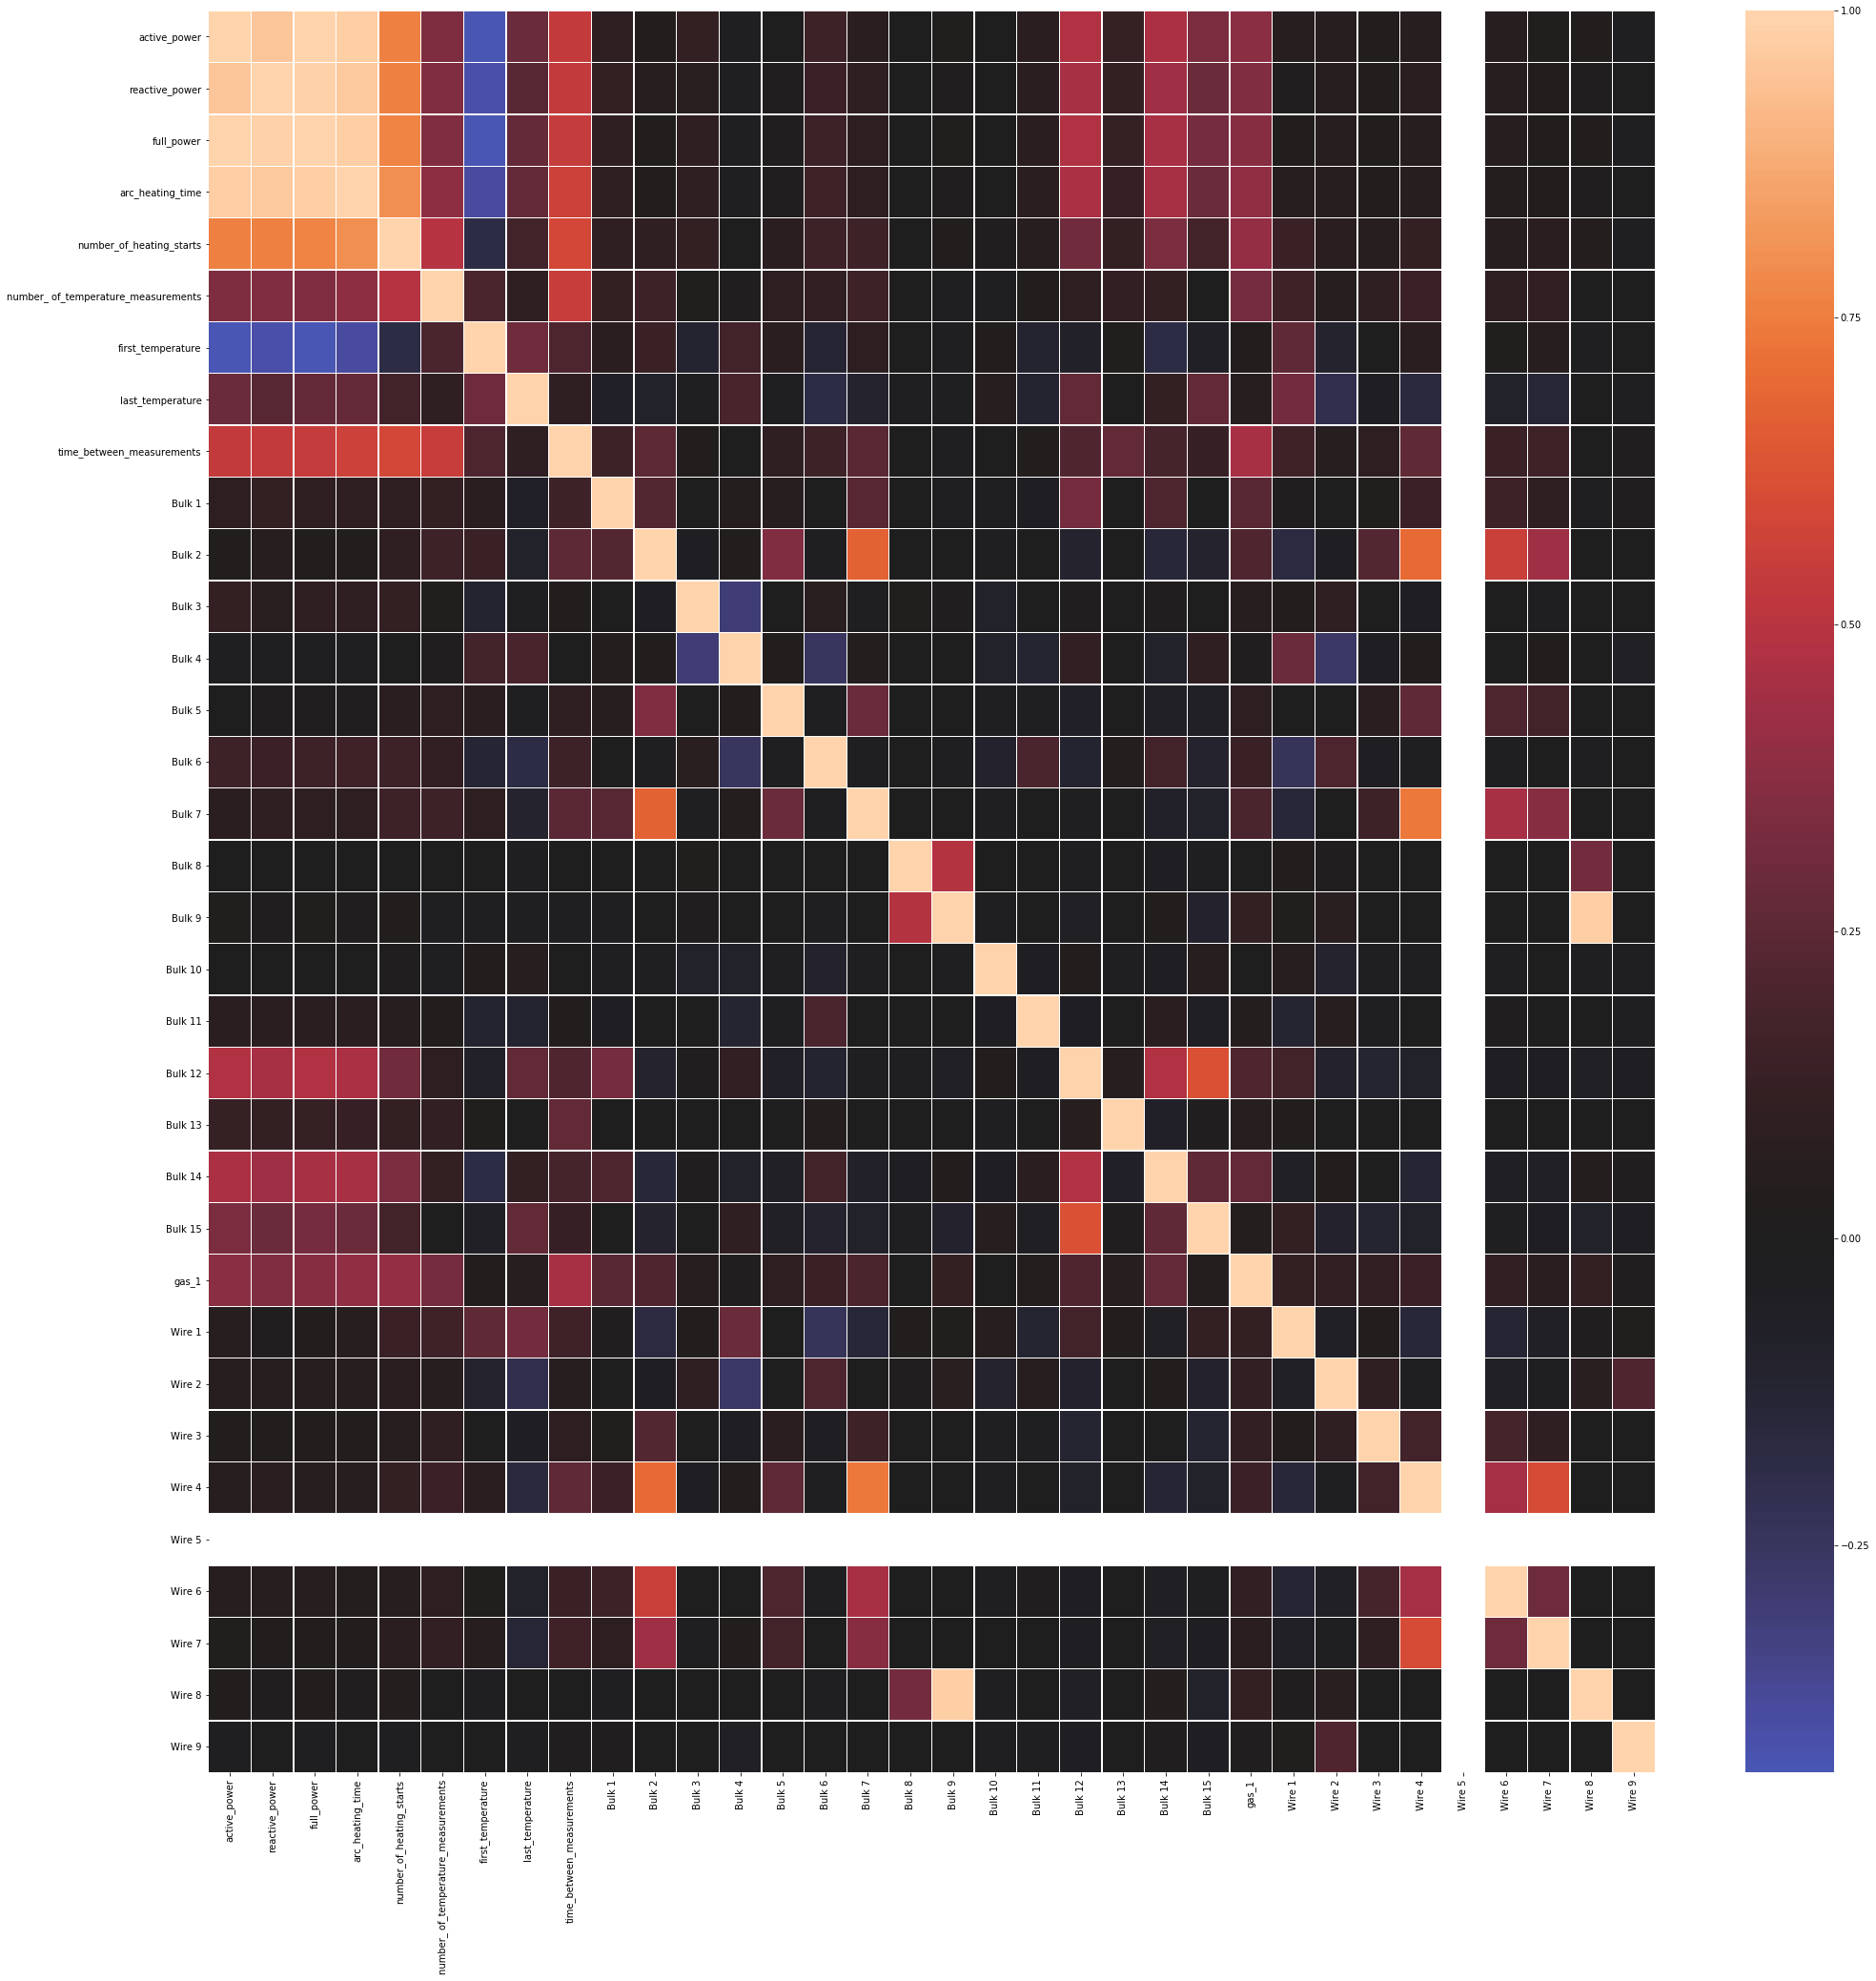

In [602]:
plt.figure(figsize=(34,34))
sns.heatmap(data_all.corr(), linewidths=0.3, center=0)

<span style="color:purple">Объяснимо высокая корреляция между активной мощностью, реактивной мощностью и полной мощностью. Также очень высокая зависимость между этими параметрами и временем нагрева дугой. Из неожиданностей - очень высокая корреляция между wire_8 и bulk_9 (заметим, что и там, и там по 19 ненулевых объёктов).

<span style="color:purple">Разделим данные на признаки и целевой признак.<span>

In [603]:
features = data_all.drop(['last_temperature'], axis=1)
target = data_all['last_temperature']

<span style="color:purple">Разобьём выборки на обучающую и тестовую в соотношении 4:1.<span>

In [604]:
features_train, features_test, target_train, target_test = train_test_split(features, target, \
                                                                                          test_size=0.2, random_state=RS)

In [605]:
display(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(1863, 33)

(466, 33)

(1863,)

(466,)

## 3. Подбор и тестирование моделей<a class="anchor" id="3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Попробуем подобрать лучшие параметры для моделей с помощью GridSearchCV. Кросс-валидацию будем проводить на трёх подвыборках.

In [606]:
def mae(target, predictions):
    mae = mean_absolute_error(target, predictions)
    return mae

In [607]:
mae_scorer = make_scorer(mae, greater_is_better = False)

<span style="color:purple">Напишем функцию ранжирования признаков по важности.

In [608]:
def importances(model):
    importances = model.feature_importances_
    feature_list = list(features_train.columns)
    feature_results = pd.DataFrame({'feature': feature_list,'importance': importances}).\
    sort_values('importance',ascending = False).reset_index(drop=True)

    display(feature_results.head(10))
    
    plt.figure(figsize=(20,12))
    f_importances = pd.Series(importances, index=features_train.columns)
    f_importances.nlargest(10).plot(kind='barh')
    plt.title('Рейтинг признаков')

## 3.1. Линейная регрессия<a class="anchor" id="3.1-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Подберём наилучшие параметры.<span>

In [609]:
%%time
param_liner = {'copy_X':[True, False], 'fit_intercept':[True, False], 'normalize':[True, False]}

gs_liner = GridSearchCV(LinearRegression(), param_liner, cv = 3, scoring = mae_scorer)
gs_liner.fit(features_train, target_train)
params = gs_liner.best_params_
display(gs_liner.best_params_)

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

CPU times: user 1.21 s, sys: 1.17 s, total: 2.38 s
Wall time: 2.36 s


<span style="color:purple">Обучим модель на наилучших параметрах.<span>

In [610]:
%%time
liner = LinearRegression(**params)
liner.fit(features_train, target_train)

CPU times: user 62.3 ms, sys: 44.1 ms, total: 106 ms
Wall time: 187 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

<span style="color:purple">Сделаем предсказание на тестовой выборке и вычислим mae.<span>

In [611]:
%%time
predictions = liner.predict(features_test)
mae_liner = mae(target_test, predictions)
display(mae_liner)

5.224964040035112

CPU times: user 25.2 ms, sys: 35.2 ms, total: 60.4 ms
Wall time: 96.5 ms


## 3.2. Случайный лес<a class="anchor" id="3.2-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Подберём наилучшие параметры.<span>

In [612]:
%%time
param_forest = {'n_estimators': [500, 600], 'max_depth': [6, 7], 'min_samples_split': [2, 3]}

gs_forest = GridSearchCV(RandomForestRegressor(random_state = RS), param_forest, scoring = mae_scorer, cv = 3)
gs_forest.fit(features_train, target_train)
params = gs_forest.best_params_
display(gs_forest.best_params_)

{'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 500}

CPU times: user 1min 36s, sys: 0 ns, total: 1min 36s
Wall time: 1min 42s


<span style="color:purple">Обучим модель на наилучших параметрах.<span>

In [613]:
%%time
forest = RandomForestRegressor(**params, random_state = RS)
forest.fit(features_train, target_train)

CPU times: user 5.19 s, sys: 0 ns, total: 5.19 s
Wall time: 5.41 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=100500,
                      verbose=0, warm_start=False)

<span style="color:purple">Сделаем предсказание на тестовой выборке и вычислим mae.<span>

In [614]:
%%time
predictions = forest.predict(features_test)
mae_forest = mae(target_test, predictions)
display(mae_forest)

5.839568713946411

CPU times: user 70.9 ms, sys: 0 ns, total: 70.9 ms
Wall time: 69.2 ms


<span style="color:purple">Посмотрим на важность факторов.

,feature,importance
0,first_temperature,0.263016
1,active_power,0.187752
2,Bulk 6,0.088018
3,time_between_measurements,0.066321
4,Wire 1,0.061129
5,Bulk 7,0.049955
6,arc_heating_time,0.042756
7,Wire 2,0.034742
8,full_power,0.025518
9,Bulk 14,0.021032


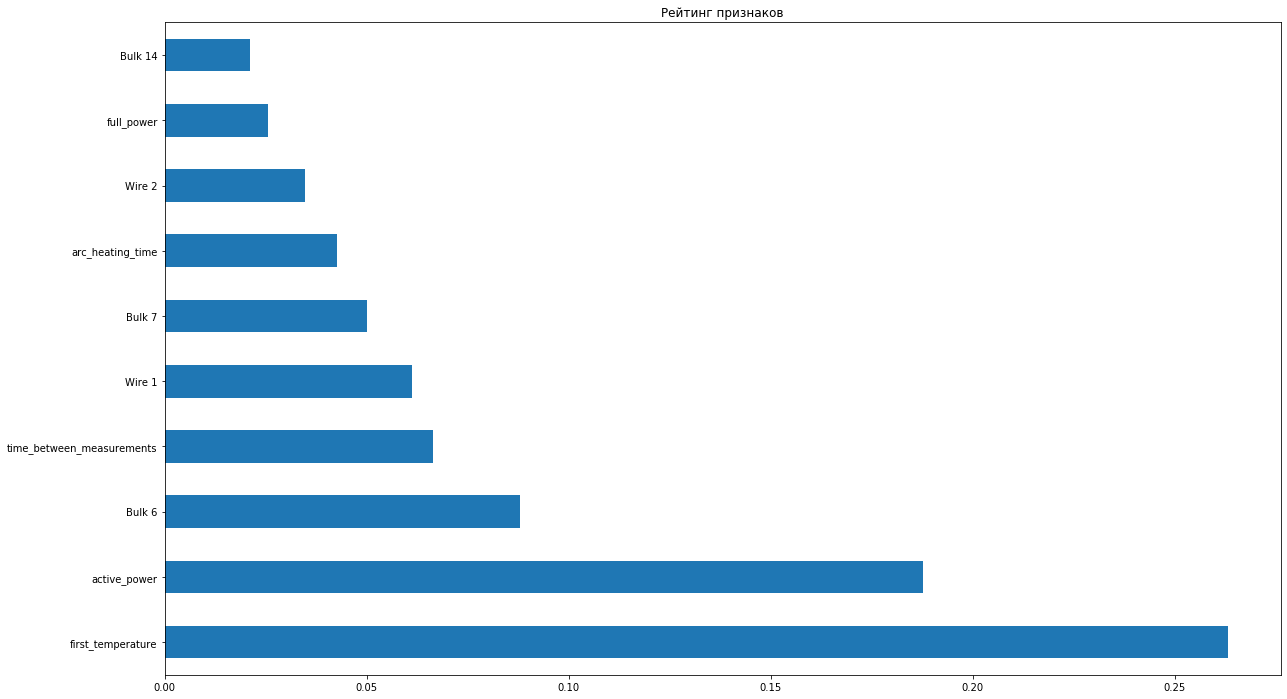

In [615]:
importances(forest)

## 3.3. CatBoostRegressor<a class="anchor" id="3.3-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Подберём наилучшие параметры.<span>

In [ ]:
%%time
param_cb = {'max_depth': [6, 8], 'learning_rate': [0.05, 0.1], 'n_estimators': [800], 'l2_leaf_reg': [1, 3]}

gs_cb = GridSearchCV(CatBoostRegressor(random_state=RS), param_cb, scoring = mae_scorer, cv = 3)
gs_cb.fit(features_train, target_train)
params = gs_cb.best_params_
display(gs_cb.best_params_)

0:	learn: 11.3614237	total: 2.15ms	remaining: 1.72s
1:	learn: 11.1887929	total: 4.27ms	remaining: 1.71s
2:	learn: 11.0381181	total: 6.18ms	remaining: 1.64s
3:	learn: 10.8906150	total: 8.14ms	remaining: 1.62s
4:	learn: 10.7589264	total: 15.5ms	remaining: 2.47s
5:	learn: 10.6407954	total: 37.7ms	remaining: 4.99s
6:	learn: 10.5104931	total: 39.6ms	remaining: 4.49s
7:	learn: 10.4207739	total: 41.5ms	remaining: 4.11s
8:	learn: 10.2983972	total: 43.4ms	remaining: 3.81s
9:	learn: 10.1918155	total: 50.6ms	remaining: 4s
10:	learn: 10.1110313	total: 135ms	remaining: 9.7s
11:	learn: 10.0061681	total: 137ms	remaining: 9.01s
12:	learn: 9.9109713	total: 139ms	remaining: 8.42s
13:	learn: 9.8319800	total: 141ms	remaining: 7.94s
14:	learn: 9.7236486	total: 143ms	remaining: 7.5s
15:	learn: 9.6188551	total: 234ms	remaining: 11.4s
16:	learn: 9.5245104	total: 236ms	remaining: 10.9s
17:	learn: 9.4382567	total: 239ms	remaining: 10.4s
18:	learn: 9.3445787	total: 242ms	remaining: 9.96s
19:	learn: 9.2602853	tot

<span style="color:purple">Обучим модель на наилучших параметрах.<span>

In [ ]:
%%time
cb = CatBoostRegressor(**params)
cb.fit(features_train, target_train)

<span style="color:purple">Сделаем предсказание на тестовой выборке и вычислим mae.<span>

In [ ]:
%%time
predictions = cb.predict(features_test)
mae_cb = mae(target_test, predictions)
display(mae_cb)

<span style="color:purple">Посмотрим на важность факторов.

In [ ]:
importances(cb)

## 3.4. LGBMRegressor<a class="anchor" id="3.4-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Подберём наилучшие параметры.<span>

In [ ]:
%%time
param_lgbm = {'max_depth': [8, 9], 'learning_rate': [0.05, 0.1], 'n_estimators': [600, 800]}

gs_lgbm = GridSearchCV(LGBMRegressor(random_state=RS), param_lgbm, scoring = mae_scorer, cv = 3)
gs_lgbm.fit(features_train, target_train)
params = gs_lgbm.best_params_
display(gs_lgbm.best_params_)

<span style="color:purple">Обучим модель на наилучших параметрах.<span>

In [ ]:
%%time
lgbm = LGBMRegressor(**params)
lgbm.fit(features_train, target_train)

<span style="color:purple">Сделаем предсказание на тестовой выборке и вычислим mae.<span>

In [ ]:
%%time
predictions = lgbm.predict(features_test)
mae_lgbm = mae(target_test, predictions)
display(mae_lgbm)

<span style="color:purple">Посмотрим на важность факторов.

In [ ]:
importances(lgbm)

<span style="color:purple">Самым важным признаком для моделей является начальная температура. Также очень значимы активная мощность и время между первым и последним измерениями температуры.

<span style="color:purple">Сведём полученные результаты в единую таблицу.<span>

In [ ]:
results = {'Модель':['Линейная регрессия', 'Случайный лес', 'CatBoostRegressor', 'LGBMRegressor'], 
        'mae': ['5.22', '5.84', '5.33', '5.65']}
df_results = pd.DataFrame(results)
display(df_results)

<span style="color:purple">Все модели показали хороший результат метрики mae и преодолели психологически важную отметку в 6%. Победила линейная регрессия: mae = 5.22 c подобранными гиперпараметрами (copy_X=True, fit_intercept=True, n_jobs=None, normalize=True). На втором месте модель CatBoostRegressor с результатом mae = 5.33, на третьем - LGBMRegressor с mae = 5.65.

## 3.5. Проверка адекватности модели<a class="anchor" id="3.5-bullet"></a>
👈[назад к оглавлению](#0-bullet)

<span style="color:purple">Для оценки адекватности сравним получившееся предсказание с предсказанием для константной модели. Для этого будем использовать DummyRegressor.

In [ ]:
dum = DummyRegressor(strategy = 'mean')
dum.fit(features_train, target_train)
predictions = dum.predict(features_test)
mae_dum = mae(target_test, predictions)
display(mae_dum)

<span style="color:purple">Таким образом, наша лучшая модель оказалась на 56% эффективнее, чем обычная константная модель. 